# 6.3 学習曲線と検証曲線によるアルゴリズムの診断
- 学習アルゴリズムの性能を向上させるのに役立つ学習曲線と検証曲線を取り上げる。

# 6.3.1 学習曲線を使ってバイアスとバリアンスの問題を診断する
- 過学習を抑えるためにトレーニングサンプルをたくさん集める事が役立つ事があるが、一般にそのコストは高い。
- バイアスが高いモデルでは、トレーニングと交差検証の正解率が低く、学習不足である。この問題に対処する一般的な方法は、モデルのパラメータを増やすことである。例えば、追加する特徴量を収集または生成するか、SVMやロジスティック回帰の分類器で正則化の強度を下げる必要がある。
- バリアンスが高いモデルでは、トレーニングと交差検証の精度に大きな差がある場合である。トレーニングデータを更に増やすか、正則化のパラメータを増やすなどして、モデルの複雑さを抑えれば良い。正則化されたいなモデルでは特徴量の個数を減らすのも効果的である。

In [1]:
import pandas as pd
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data',header=None)

In [2]:
#特徴量をX、ターゲットをyに格納
from sklearn.preprocessing import LabelEncoder
import numpy as np
X = df.loc[:,2:].values
y = df.loc[:,1].values
#クラスラベルの文字列表現を整数に変換する
le = LabelEncoder()
y = le.fit_transform(y)

In [3]:
#トレーニングデータセットとテストデータセットに分割する
from sklearn.cross_validation import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.20,random_state=1)

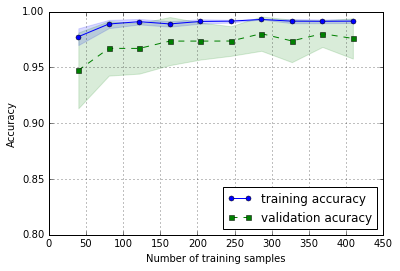

In [8]:
#scikit-learnで学習曲線関数を使ってモデルを評価する方法
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.learning_curve import learning_curve
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import numpy as np

pipe_lr = Pipeline([('scl',StandardScaler()),('clf',LogisticRegression(penalty='l2',random_state=0))])

#learning_curveを使って交差検証による正解率を算出
train_sizes,train_scores,test_scores = learning_curve(estimator=pipe_lr,
                                                      X=X_train,y=y_train,
                                                      train_sizes=np.linspace(0.1,1.0,10),
                                                      cv=10,
                                                      n_jobs=1)
train_mean = np.mean(train_scores,axis=1)
train_std = np.std(train_scores,axis=1)
test_mean = np.mean(test_scores,axis=1)
test_std = np.std(test_scores,axis=1)
plt.plot(train_sizes,train_mean,color='blue',marker='o',markersize=5,label='training accuracy')
#fill_between関数で平均+-標準偏差の幅を塗りつぶす。
#トレーニングデータのサイズtrain_sizes,透明度alpha,カラーblueを引数に指定
plt.fill_between(train_sizes,train_mean + train_std,train_mean - train_std,alpha=0.15,color='blue')

plt.plot(train_sizes,test_mean,color='green',linestyle='--',marker='s',markersize=5,label='validation acuracy')
plt.fill_between(train_sizes,test_mean+test_std,test_mean-test_std,alpha=0.15,color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8,1.0])
plt.show()

# 6.3.2 検証曲線を使って過学習と学習不足を明らかにする。
- 検証曲線は過学習や学習不足と言った問題を特定することにより、モデルの性能を改善するのに役立つツールである。
- 検証曲線はサンプルサイズの代わりにモデルのパラメータの値を変化させる。
- 例えばロジスティック回帰の逆正則化パラメータCを変化させる。

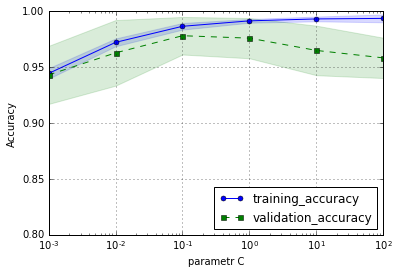

In [12]:
from sklearn.learning_curve import validation_curve
param_range = [0.001,0.01,0.1,1.0,10.0,100.0]
#validation_curve関数によりもｄるのパラメータを変化させる。
#交差検証による正解率を算出
#clf_CはLogisticRegressionオブジェクトのパラメータ
train_scores,test_scores = validation_curve(estimator=pipe_lr,
                                         X=X_train,
                                         y=y_train,
                                         param_name='clf__C',#pipline内のLogisticRegressionオブジェクトにアクセスclf__C
                                         param_range=param_range,
                                         cv=10)
train_mean = np.mean(train_scores,axis=1)
train_std = np.std(train_scores,axis=1)
test_mean = np.mean(test_scores,axis=1)
test_std = np.std(test_scores,axis=1)

plt.plot(param_range,train_mean,color='blue',marker='o',markersize=5,label='training_accuracy')
plt.fill_between(param_range,train_mean+train_std,train_mean-train_std,alpha=0.15,color='blue')
plt.plot(param_range,test_mean,color='green',marker='s',linestyle='--',markersize=5,label='validation_accuracy')
plt.fill_between(param_range,test_mean+test_std,test_mean-test_std,alpha=0.15,color='green')

plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('parametr C')
plt.ylabel('Accuracy')
plt.ylim([0.8,1.0])
plt.show()

- learning_curve関数と同様に、validation_curve関数はデフォルトで層化k分割交差検証を使用し、分類のアルゴリズムを使用している場合はモデルの性能を評価している。

# 6.4 グリッドサーチによる機械学習モデルのチューニング
- 機械学習には、ロジスティック回帰の重み係数の様にトレーニングデータから学習されるパラメータと、個別に最適化されるチューニングパラメータ（ハイパーパラメータとも呼ぶ）の２種類がある。
- グリッドサーチは、ハイパーパラメータの値の「最適な」組み合わせを見つけ出すことにより、モデルの性能をさらに改善するのに役立つ

# 6.4.1 グリッドサーチを使ってハイパーパラメータをチューニングする
- グリッドサーチはしらみつぶしの網羅的探索手法である。
- さまざまなハイパーパラメータの値からなるリストを指定すると、それらの組み合わせ毎にモデルの性能を評価する。

In [41]:
from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVC
pipe_svc = Pipeline([('scl',StandardScaler()),
                    ('clf',SVC(random_state=1))])
param_range = [10**i for i in range(-4,4)]
param_grid = [{'clf__C':param_range,'clf__kernel':['linear']},
              {'clf__C':param_range,'clf__gamma':param_range,'clf__kernel':['rbf']}]
#ハイパーパラメータ値のリストparam_gridを指定し、グリッドサーチを行うGridSearchCVクラスのインスタンス化
gs = GridSearchCV(estimator=pipe_svc,
                 param_grid=param_grid,
                 scoring='accuracy',
                 cv=10,
                 n_jobs=-1)
gs = gs.fit(X_train,y_train)
#モデルの最良スコアを出力
print(gs.best_score_)
#最良となるパラメータ値を出力
print(gs.best_params_)

0.978021978022
{'clf__C': 0.1, 'clf__kernel': 'linear'}


In [21]:
clf = gs.best_estimator_ #最適化された推定器を抽出 pipelineオブジェクト
clf.fit(X_train,y_train)
print('Test accuracy: %.3f') %clf.score(X_test,y_test)

Test accuracy: 0.965


# 6.4.2 入れ子式の交差検証によるアルゴリズムの選択
- 様々な機械学習のアルゴリズムの中からどれかを選択したい場合は、入れ子式の交差検証も推奨される。
- 外側のループでは、k分割交差検証を使って、トレーニングサブセットとテストサブセットにデータを分割する。
- 内側のループでは、トレーニングサブセットに対してk分割交差検証を行うことでパラメータをチューニングしモデルを選択する。
- モデルを選択したあと、テストサブセットを使って性能を評価する。

In [46]:
from sklearn.cross_validation import cross_val_score
gs = GridSearchCV(estimator=pipe_svc,
               param_grid=param_grid,
               scoring='accuracy',
               cv=2,
               n_jobs=-1)
scores = cross_val_score(gs,X_train,y_train,scoring='accuracy',cv=5)
print('CV accuracy: %.3f +/- %.3f') %(np.mean(scores),np.std(scores))

CV accuracy: 0.965 +/- 0.025


- 返された交差検証の正解率から、モデルのハイパーパラメータをチューニングし、それらのパラメータを未知のデータに使用したらどうなるかを適切に選択できる。
- 例えば入れ子式の交差検証法を使用することで、SVMモデルを単純な決定木分類と比較できる。

In [49]:
from sklearn.tree import DecisionTreeClassifier
# ハイパーパラメータ値として決定木の深さパラメータを指定し、グリッドリサーチを行う
gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=0),
                 param_grid=[{'max_depth':[1,2,3,4,5,6,7,None]}],
                 scoring='accuracy',
                 cv=2)
scores = cross_val_score(gs,X_train,y_train,scoring='accuracy',cv=5)
print('CV accuracy: %.3f +/- %.3f') %(np.mean(scores),np.std(scores))

CV accuracy: 0.921 +/- 0.029
